# RL Project - Deep Q Network 

In [1]:
import math
import os
import random

import gym
import matplotlib.pyplot as plt
import minihack
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import spaces
from nle import nethack
from PIL import Image
from torch import flatten
from torch.nn import (BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout, Linear,
                      MaxPool2d, Module, ReLU, Sequential, Softmax)

In [2]:
# Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [3]:
def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [4]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [5]:
def read_results(path):
    """Function to read in and format saved results"""
    df = pd.read_csv(path)
    results = []
    for i in range(5):
        results.append(df.loc[i].to_list())
    return results

In [6]:
def format_state(state):
    """Formats state into form that the NN can accept"""
    glyphs = state["glyphs"]
    # Normalize
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    return torch.from_numpy(glyphs).squeeze(0)

In [7]:
def plot_results(env_name,scores, color='blue'):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"DQN - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

## DQN Model

The implemented DQN was largely based on the rail lab implementation which can be found here: https://github.com/raillab/dqn.
The NN architecture was changed to suit the smaller input and experimented with to obtain the best results. 

In [8]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

In [9]:
class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network.
    """

    def __init__(self, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param action_space: the action space of the environment
        """
        super().__init__()
        
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=action_space.n)


    def forward(self, x):
        """
        Returns the values of a forward pass of the network
        :param x: The input to feed into the network 
        """
        # define first conv layer with max pooling
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # define second conv layer with max pooling
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # Define fully connected layers
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [10]:
# Define class that brings all the DQN compenents together so that a model can be trained
class DQNAgent():
    def __init__(self, observation_space, action_space, **kwargs):
        global device
        self.action_space = action_space
        self.replay_buffer = kwargs.get("replay_buffer", None)
        self.use_double_dqn = kwargs.get("use_double_dqn", None)
        self.gamma = kwargs.get("gamma", 0.99)
        self.lr = kwargs.get("lr", None)
        self.betas = kwargs.get("betas", (0.9, 0.999))
        self.batch_size = kwargs.get("batch_size", None)
        # Create the online and target network
        self.online_network = DQN(action_space).to(device)
        self.target_network = DQN(action_space).to(device)
        self.optimiser = torch.optim.Adam(self.online_network.parameters(), lr=self.lr, betas=self.betas)
   

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        with torch.no_grad():
            if self.use_double_dqn:
                _, max_next_action = self.online_network(next_states).max(1)
                max_next_q_values = self.target_network(next_states).gather(1, max_next_action.unsqueeze(1)).squeeze()
            else:
                next_q_values = self.online_network(next_states)
                max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        input_q_values = self.target_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        del states
        del next_states
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.online_network.state_dict())

    def act(self, observation):
        """Select action base on network inference"""
        if not torch.cuda.is_available():
            observation = observation.type(torch.FloatTensor) 
        else:
            observation = observation.type(torch.cuda.FloatTensor) 
        state = torch.unsqueeze(observation, 0).to(device)
        result = self.online_network.forward(state)
        action = torch.argmax(result).item()
        return action


## DQN Method

In [11]:
def dqn(env, seed, learning_rate, max_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train DQN model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """

    hyper_params = {
        'replay-buffer-size': int(1e6),
        'learning-rate': 0.01,
        'gamma': 0.99,  # discount factor
        'num-steps': int(2e5),  # Steps to run for, max episodes should be hit before this
        'batch-size': 32,  
        'learning-starts': 1000,  # set learning to start after 1000 steps of exploration
        'learning-freq': 1,  # Optimize after each step
        'use-double-dqn': True,
        'target-update-freq': 1000, # number of iterations between every target network update
        'eps-start': 1.0,  # e-greedy start threshold 
        'eps-end': 0.1,  # e-greedy end threshold 
        'eps-fraction': 0.4,  # Percentage of the time that epsilon is annealed
        'print-freq': 10,

    }
    
    np.random.seed(seed)
    env.seed(seed)
    
    # Create DQN agent
    replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
    agent = DQNAgent(
        env.observation_space, 
        env.action_space,
        train=True,
        replay_buffer=replay_buffer,
        use_double_dqn=hyper_params['use-double-dqn'],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['gamma'],
    )
    
    # define variables to track agent metrics
    total_reward = 0
    scores = []
    mean_rewards = []

    # Reset gym env before training
    state = format_state(env.reset())
    eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])
    # Train for set number of steps
    for t in range(hyper_params['num-steps']):
        # determine exploration probability
        fract = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
        sample = random.random()
        # Decide to explore and choose random action or use model to act
        if sample < eps_threshold:
            action = np.random.choice(agent.action_space.n)
        else:
            action = agent.act(state)
        # Take step in environment
        (next_state, reward, done, _) = env.step(action)
        next_state = format_state(next_state)
        replay_buffer.add(state, action, reward, next_state, float(done))
        total_reward += reward
        state = next_state
        if done:
            scores.append(total_reward)
            print(f"episode reward: {total_reward}")
            np.random.seed(seed)
            env.seed(seed)
            state = format_state(env.reset())
            total_reward = 0

        if t > hyper_params['learning-starts'] and t % hyper_params['learning-freq'] == 0:
            ans = agent.optimise_td_loss()

        if t > hyper_params['learning-starts'] and t % hyper_params['target-update-freq'] == 0:
            agent.update_target_network()

        num_episodes = len(scores)
        if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
            mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
            mean_rewards.append(mean_100ep_reward)
            print('********************************************************')
            print('steps: {}'.format(t))
            print('episodes: {}'.format(num_episodes))
            print('mean 100 episode reward: {}'.format(mean_100ep_reward))
            print('% time spent exploring: {}'.format(eps_threshold))
            print('********************************************************')
  
        if num_episodes >=max_episodes:
            return scores

    return scores

In [12]:
def run_dqn(env,number_episodes,max_episode_length,iterations):
    """Trains DQN model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        print(seed)
        # Train the DQN Model 
        scores = dqn(env=env, 
                            seed=seed, 
                            learning_rate=0.01,
                            max_episodes=1000, 
                            max_episode_length=1000, 
                            gamma=0.99 ,
                            verbose=True)
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## Navigation - Room 5x5 
Training model on Room 5x5 environment

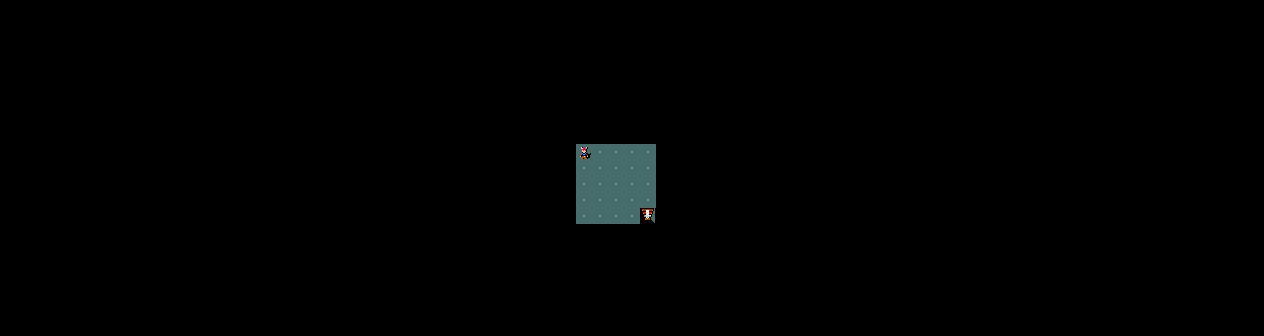

In [14]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [57]:
# Train DQN on room 5x5
room_5x5_scores = run_dqn(env,number_episodes=500,max_episode_length=200,iterations=5)
# The results from a training iteration have been saved and the output of this cell is blank to keep the notebook clean
# Please run cell if you want to train your own model

### Plot results from saved previously run experiment

In [13]:
room_5x5_scores = read_results("DQN_results/room_5x5_rewards.csv")

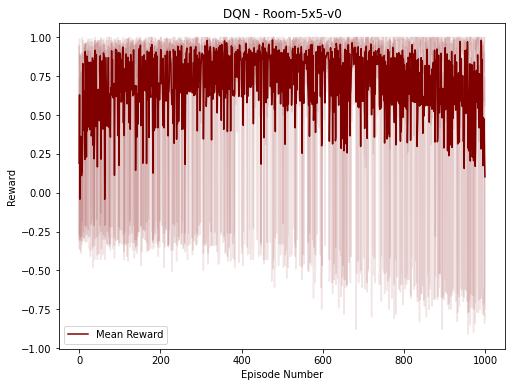

In [14]:
plot_results(env_name="Room-5x5-v0", scores=room_5x5_scores, color = "maroon")

## Skill Aquistion - Eat
Training model on Eat environment

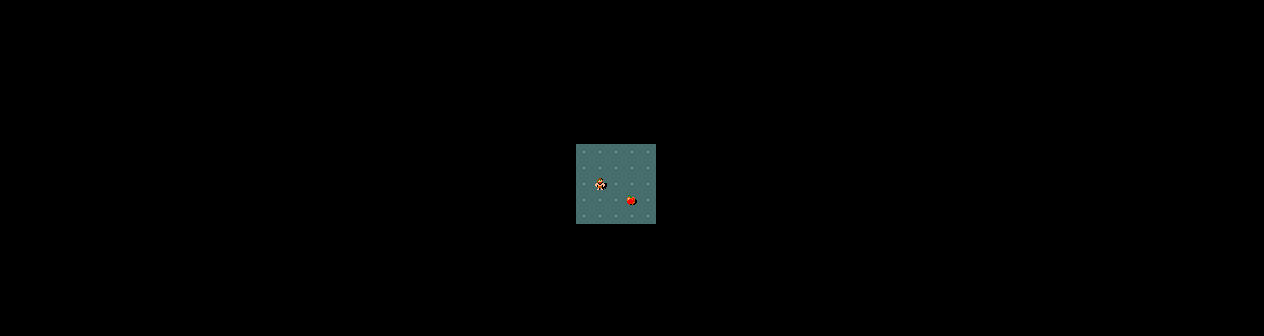

In [35]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
MOVE_ACTIONS += (nethack.Command.EAT,)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [ ]:
# Train DQN on eat
eat_scores = run_dqn(env,number_episodes=500,max_episode_length=200,iterations=5)
# The results from a training iteration have been saved and the output of this cell is blank to keep the notebook clean
# Please run cell if you want to train your own model

### Plot results from saved previously run experiment 

In [15]:
eat_scores = read_results("DQN_results/eat_rewards.csv")

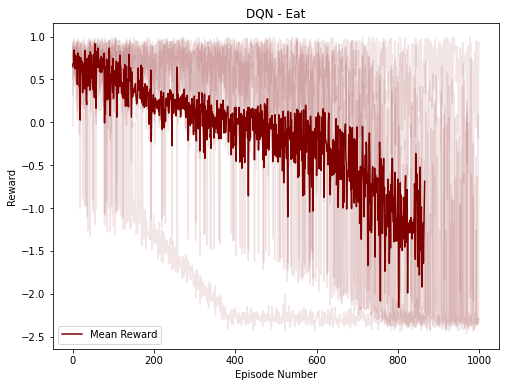

In [16]:
plot_results(env_name="Eat", scores=eat_scores, color = "maroon")

## Navigation - Quest Hard
Training model on Quest Hard environment

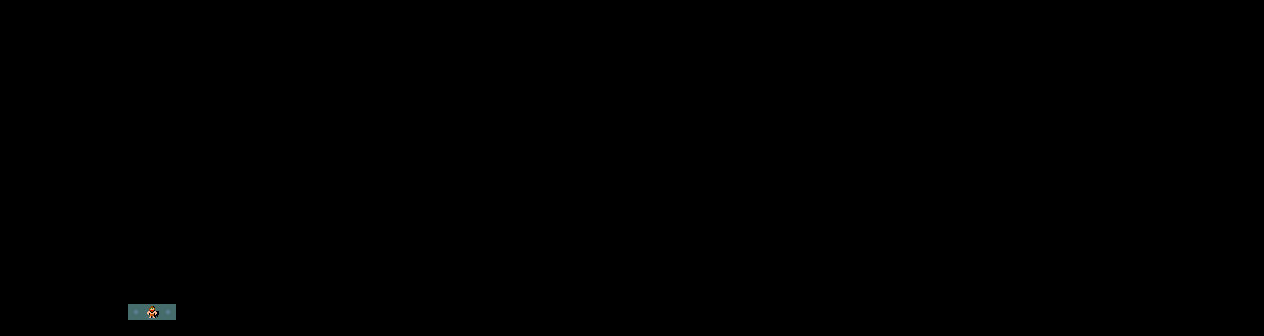

In [16]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY,
    )
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"], actions=NAVIGATE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [18]:
# Train DQN on Quest Hard
quest_hard_scores = run_dqn(env,number_episodes=500,max_episode_length=200,iterations=5)
# The results from a training iteration have been saved and the output of this cell is blank to keep the notebook clean
# Please run cell if you want to train your own model

### Plot results from saved previously run experiment 

In [8]:
quest_hard_scores = read_results("DQN_results/quest_hard_rewards.csv")

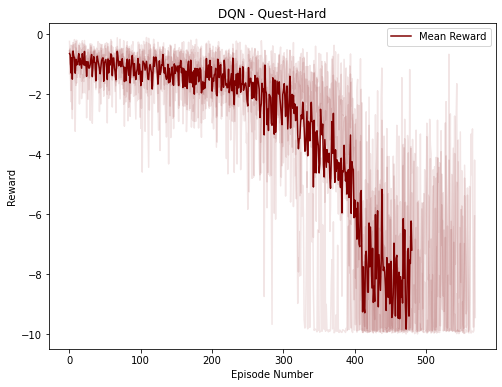

In [9]:
plot_results(env_name="Quest-Hard", scores=quest_hard_scores, color = "maroon")